In [1]:
import pandas as pd

from orion.data import load_signal

# 1. Data

In [2]:
signal_name = 'S-1'

data = load_signal(signal_name)

data.head()

,timestamp,value
0,1222819200,-0.366359
1,1222840800,-0.394108
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


In [3]:
indices = [(0,1), (5, 10), (350, 370), (4600, 5000)]

for start, end in indices:
    data.loc[start: end, 'value'] = None

In [4]:
data.head()

,timestamp,value
0,1222819200,NaN
1,1222840800,NaN
2,1222862400,0.403625
3,1222884000,-0.362759
4,1222905600,-0.370746


# 2. Pipeline

In [5]:
from mlblocks import MLPipeline

pipeline_name = 'lstm'

pipeline = MLPipeline(pipeline_name)

Using TensorFlow backend.


In [6]:
hyperparameters = {
    'keras.Sequential.LSTMTimeSeriesRegressor#1': {
        'epochs': 5,
        'verbose': True
    }
}

pipeline.set_hyperparameters(hyperparameters)

## step by step execution

MLPipelines are compose of a squence of primitives, these primitives apply tranformation and calculation operations to the data and updates the variables within the pipeline. To view the primitives used by the pipeline, we access its `primtivies` attribute. 

The `lstm_dynamic_threshold` contains 7 primitives. we will observe how the `context` (which are the variables held within the pipeline) are updated after the execution of each primitive.

In [7]:
pipeline.primitives

['mlprimitives.custom.timeseries_preprocessing.time_segments_aggregate',
 'sklearn.preprocessing.MinMaxScaler',
 'pandas.isnull',
 'mlprimitives.custom.timeseries_preprocessing.rolling_window_sequences',
 'numpy.isin',
 'keras.Sequential.LSTMTimeSeriesRegressor',
 'orion.primitives.timeseries_preprocessing.masked_array',
 'orion.primitives.timeseries_preprocessing.masked_array',
 'orion.primitives.timeseries_errors.regression_errors',
 'orion.primitives.timeseries_preprocessing.masked_array',
 'orion.primitives.timeseries_anomalies.find_anomalies']

### time segments aggregate
this primitive creates an equi-spaced time series by aggregating values over fixed specified interval.

* **input**: `X` which is an n-dimensional sequence of values.
* **output**:
    - `X` sequence of aggregated values, one column for each aggregation method.
    - `index` sequence of index values (first index of each aggregated segment).

In [8]:
context = pipeline.fit(data, output_=0)
context.keys()

dict_keys(['X', 'index'])

In [9]:
for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [nan]
entry at 1222840800 has value [nan]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


### SimpleImputer
this primitive is an imputation transformer for filling missing values.
* **input**: `X` which is an n-dimensional sequence of values.
* **output**: `X` which is a transformed version of X.

In [10]:
step = 1

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X'])

### MinMaxScaler
this primitive transforms features by scaling each feature to a given range.
* **input**: `X` the data used to compute the per-feature minimum and maximum used for later scaling along the features axis.
* **output**: `X` which is a transformed version of X.

In [11]:
step = 2

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'X', 'drop'])

In [12]:
# after scaling the data between [-1, 1]
# in this example, no change is observed
# since the data was pre-handedly scaled

for i, x in list(zip(context['index'], context['X']))[:5]:
    print("entry at {} has value {}".format(i, x))

entry at 1222819200 has value [nan]
entry at 1222840800 has value [nan]
entry at 1222862400 has value [0.4036246]
entry at 1222884000 has value [-0.36275906]
entry at 1222905600 has value [-0.37074649]


### rolling window sequence
this primitive generates many sub-sequences of the original sequence. it uses a rolling window approach to create the sub-sequences out of time series data.

* **input**: 
    - `X` n-dimensional sequence to iterate over.
    - `index` array containing the index values of X.
* **output**:
    - `X` input sequences.
    - `y` target sequences.
    - `index` first index value of each input sequence.
    - `target_index` first index value of each target sequence.

In [13]:
step = 3

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'X', 'y', 'dropped_index', 'target_index'])

In [14]:
# after slicing X into multiple sub-sequences
# we obtain a 3 dimensional matrix X where
# the shape indicates (# slices, window size, 1)
# and similarly y is (# slices, target size)

print("X shape = {}\ny shape = {}\nindex shape = {}\ntarget index shape = {}".format(
    context['X'].shape, context['y'].shape, context['index'].shape, context['target_index'].shape))

X shape = (8966, 250, 1)
y shape = (8966, 1)
index shape = (10149,)
target index shape = (8966,)


In [15]:
context['dropped_index'].shape

(8966,)

### isin
create a mask

* **input**: 
    - `index` first index value of each input sequence.
    - `target_index` first index value of each target sequence.
* **output**: `mask` boolean sequences.

In [16]:
step = 4

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'X', 'y', 'mask'])

In [17]:
context['mask'].shape

(10149,)

### LSTMTimeSeriesRegressor
this is a prediction model with double stacked LSTM layers used as a time series regressor. you can read more about it in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**: 
    - `X` n-dimensional array containing the input sequences for the model.
    - `y` n-dimensional array containing the target sequences for the model.
* **output**: `y_hat` predicted values.

In [18]:
step = 5

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Train on 7172 samples, validate on 1794 samples
Epoch 1/5
7172/7172 [==============================] - 31s 4ms/step - loss: 0.2024 - mse: 0.2024 - val_loss: 0.1987 - val_mse: 0.1987
Epoch 2/5
7172/7172 [==============================] - 31s 4ms/step - loss: 0.1944 - mse: 0.1944 - val_loss: 0.1982 - val_mse: 0.1982
Epoch 3/5
7172/7172 [==============================] - 32s 4ms/step - loss: 0.1928 - mse: 0.1928 - val_loss: 0.1948 - val_mse: 0.1948
Epoch 4/5
7172/7172 [==============================] - 31s 4ms/step - loss: 0.1913 - mse: 0.1913 - val_loss: 0.1925 - val_mse: 0.1925
Epoch 5/5
8966/8966 [==============================] - 10s 1ms/step


dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'X', 'y', 'y_hat'])

In [19]:
for i, y, y_hat in list(zip(context['target_index'], context['y'], context['y_hat']))[:5]:
    print("entry at {} has value {}, predicted value {}".format(i, y, y_hat))

entry at 1228456800 has value [-0.36990448], predicted value [-0.23941611]
entry at 1228478400 has value [0.4036246], predicted value [-0.24305663]
entry at 1228500000 has value [-0.30507299], predicted value [-0.2358683]
entry at 1228521600 has value [-0.30006179], predicted value [-0.21675658]
entry at 1228543200 has value [-0.35593822], predicted value [-0.20430446]


### masked_array 1

create a masked array with given values

* **input**: 
    - `mask` boolean sequence.
    - `y` values sequence.
* **output**: `y` modified `y` sequences.

In [20]:
step = 6

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'y_hat', 'X', 'y'])

In [21]:
context['y'].shape

(10149, 1)

### masked_array 2

create a masked array with given values

* **input**: 
    - `mask` boolean sequence.
    - `y_hat` values sequence.
* **output**: `y_hat` modified `y_hat` sequences.

In [22]:
step = 7

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'y_hat', 'X', 'y'])

In [23]:
context['y_hat'].shape

(10149, 1)

### regression errors

this primitive computes an array of absolute errors comparing predictions and expected output. Optionally smooth them using EWMA.

* **input**: 
    - `y` ground truth.
    - `y_hat` predicted values.
* **output**: `errors` array of errors.

In [24]:
step = 8

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'y_hat', 'X', 'y', 'errors'])

In [25]:
for i, e in list(zip(context['target_index'], context['errors']))[:5]:
    print("entry at {} has error value {:.3f}".format(i, e))

entry at 1228456800 has error value nan
entry at 1228478400 has error value nan
entry at 1228500000 has error value nan
entry at 1228521600 has error value nan
entry at 1228543200 has error value nan


### masked_array 3

create a masked array with given values

* **input**: 
    - `mask` boolean sequence.
    - `errors` values sequence.
* **output**: `errors` modified `errors` sequences.

In [26]:
context['errors'].shape

(10149,)

In [27]:
step = 9

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'y_hat', 'errors', 'X', 'y'])

In [28]:
context['errors'].shape

(10149,)

### find anomalies
this primitive extracts anomalies from sequences of errors following the approach explained in the [related paper](https://arxiv.org/pdf/1802.04431.pdf).

* **input**: 
    - `errors` array of errors.
  
  - `target_index` array of indices of errors.
* **output**: `y` array containing start-index, end-index, score for each anomalous sequence that was found.

In [29]:
step = 10

context = pipeline.fit(**context, output_=step, start_=step)
context.keys()

/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: invalid value encountered in greater
  above = pd.Series(errors > epsilon)
/Users/sarahalnegheimish/opt/anaconda3/envs/orion/lib/python3.7/site-packages/orion/primitives/timeseries_anomalies.py:189: RuntimeWarning: 

dict_keys(['index', 'drop', 'dropped_index', 'target_index', 'mask', 'y_hat', 'errors', 'X', 'y', 'anomalies'])

In [30]:
anomalies = pd.DataFrame(context['anomalies'], columns=['start', 'end', 'severity'])

In [31]:
anomalies

,start,end,severity
0,1.403395e+09,1.405879e+09,0.018441


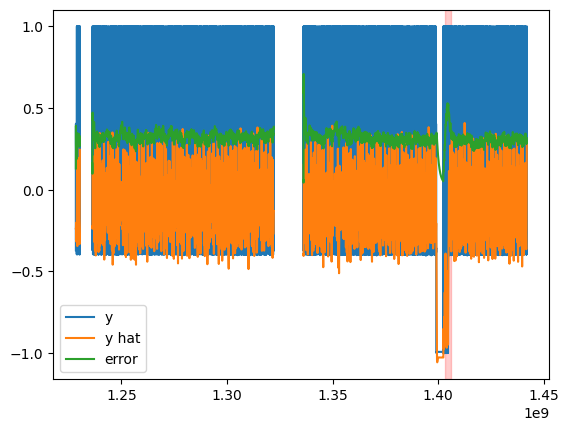

In [32]:
import matplotlib.pyplot as plt

%matplotlib inline

plt.plot(context['index'], context['y'], label='y')
plt.plot(context['index'], context['y_hat'], label='y hat')
plt.plot(context['index'], context['errors'], label='error')

for i, (start, end, sev) in anomalies.iterrows():
    plt.axvspan(start, end, color='red', alpha=0.2)

plt.legend();